## Installing necessary packages

In [1]:
!pip install transformers --q
!pip install gensim --q

## Importing necessary packages

In [2]:
import pandas as pd
import numpy as np
from numpy import zeros

from tqdm import tqdm
from gensim import corpora
import gensim


import json
import torch

from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score


import torch as th
from transformers import AutoModel, AutoTokenizer
import torch.utils.data as Data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [3]:
sequence_length = 256
embedding_dim = 256
batch_size = 32
epochs = 4
model_name = 'nlpaueb/legal-bert-base-uncased'
output_type = 'mean_pooled' # by default CLS

## Dataset Loader

#### Training dataset

In [4]:
train_df = pd.read_csv('../../data/model_data/train_df.csv')
print("# Size: ", train_df.shape)
train_df.head()

# Size:  (28836, 3)


,Unnamed: 0,sentence,label
0,0,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,1,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,2,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,3,\n\n This appeal coming on for hearing t...,PREAMBLE
4,4,\n Heard the learned Counsel for the app...,NONE


In [5]:
print("#Nan in sents: ", train_df.sentence.isnull().values.sum())
print("#Nan in labels: ", train_df.label.isnull().values.sum())

#Nan in sents:  0
#Nan in labels:  0


In [6]:
train_df.label.value_counts()

ANALYSIS          10623
FAC                5688
PREAMBLE           4164
PRE_RELIED         1431
NONE               1421
ARG_PETITIONER     1312
RPC                1080
RLC                 741
ARG_RESPONDENT      698
RATIO               672
STA                 481
ISSUE               367
PRE_NOT_RELIED      158
Name: label, dtype: int64

#### Validation dataset

In [7]:
dev_df = pd.read_csv('../../data/model_data/dev_df.csv')
print("# Size: ", dev_df.shape)
dev_df.head()

# Size:  (2890, 3)


,Unnamed: 0,sentence,label
0,0,PETITIONER:\nTHE COMMISSIONER OF INCOME-TAXNEW...,PREAMBLE
1,1,\n\nDATE OF JUDGMENT:\n05/05/1961\n\nBENCH:\nD...,PREAMBLE
2,2,"\nBENCH:\nDAS, S.K.\nHIDAYATULLAH, M.\nSHAH, J...",PREAMBLE
3,3,It\nentered into transactions in the nature of...,PREAMBLE
4,4,The assessee claimed deduction of these\nlosse...,PREAMBLE


In [8]:
print("#Nan in sents: ", dev_df.sentence.isnull().values.sum())
print("#Nan in labels: ", dev_df.label.isnull().values.sum())

#Nan in sents:  0
#Nan in labels:  0


In [9]:
dev_df.label.value_counts()

ANALYSIS          986
FAC               581
PREAMBLE          509
NONE              192
PRE_RELIED        142
RLC               116
RPC                92
RATIO              72
ARG_PETITIONER     70
ISSUE              51
ARG_RESPONDENT     38
STA                29
PRE_NOT_RELIED     12
Name: label, dtype: int64

#### Reading labels

In [10]:
le_encoder = LabelEncoder()
le_encoder.fit(list(train_df.label.values) + list(dev_df.label.values))

label_names = le_encoder.classes_
print(label_names)

['ANALYSIS' 'ARG_PETITIONER' 'ARG_RESPONDENT' 'FAC' 'ISSUE' 'NONE'
 'PREAMBLE' 'PRE_NOT_RELIED' 'PRE_RELIED' 'RATIO' 'RLC' 'RPC' 'STA']


In [11]:
ID_Label_Map = {}
with open('../../data/model_data/ID_Label_Map.json', 'r') as fp:
    ID_Label_Map = json.load(fp)

Label_ID_Map = {}
with open('../../data/model_data/Label_ID_Map.json', 'r') as fp:
    Label_ID_Map = json.load(fp)

print(list(Label_ID_Map.keys()))

['ANALYSIS', 'ARG_PETITIONER', 'ARG_RESPONDENT', 'FAC', 'ISSUE', 'NONE', 'PREAMBLE', 'PRE_NOT_RELIED', 'PRE_RELIED', 'RATIO', 'RLC', 'RPC', 'STA']


In [12]:
train_labels = le_encoder.transform(list(train_df.label.values))
print("# Labels: ", len(train_labels))

# Labels:  28836


In [13]:
dev_labels = le_encoder.transform(list(dev_df.label.values))
print("# Labels: ", len(dev_labels))

# Labels:  2890


In [14]:
dev_sentences = list(dev_df.sentence.values)
dev_actual_labels = list(dev_df.label.values)

### Preparing the data loader for bert classifier

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def encode_input_lda(token_lists, n_classes):
    dictionary = corpora.Dictionary(token_lists)
    
    corpus = [dictionary.doc2bow(text) for text in token_lists]
    n_doc = len(corpus)
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_classes, id2word = dictionary, passes=20)
    
    vec_lda = np.zeros((n_doc, n_classes))
    for i in tqdm(range(n_doc)):

        # get the distribution for the i-th document in corpus
        for topic, prob in ldamodel.get_document_topics(corpus[i]):
            vec_lda[i, topic] = prob

    return vec_lda

In [17]:
def encode_input(text, tokenizer):
    tokenized_text = tokenizer(
        text,
        max_length = sequence_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokenized_text.input_ids, tokenized_text.attention_mask

## Bert Model

In [18]:
class BertClassifier(th.nn.Module):
    def __init__(self, vec_dim, pretrained_model='bert-base-uncased', nb_class=13, embedding_dim = 512):
        super(BertClassifier, self).__init__()
        self.nb_class = nb_class
        self.embedding_dim = embedding_dim
        
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
        self.bert_model = AutoModel.from_pretrained(pretrained_model)
        
        self.feat_dim_1 = list(self.bert_model.modules())[-2].out_features
        self.classifier_1 = th.nn.Linear(self.feat_dim_1, self.embedding_dim)
        
        self.feat_dim_2 = vec_dim
        
        self.classifier = th.nn.ModuleList([th.nn.Linear(self.feat_dim_2 + self.embedding_dim, 1) for _ in range(self.nb_class)])

    def forward(self, lda_vec=None, input_ids=None, attention_mask=None, output_type = 'CLS'):
        bert_output = None
        if output_type=='mean_pooled':
            output = self.bert_model(input_ids, attention_mask).last_hidden_state
            
            ### Mean Pooling
            bert_output = output.sum(axis=1) / attention_mask.sum(axis=-1).unsqueeze(-1)
        else:
            bert_output = self.bert_model(input_ids, attention_mask)[0][:, 0]

        bert_output = torch.squeeze(bert_output)
        last_hidden_opt = torch.squeeze(self.classifier_1(bert_output))
        
        vec = torch.squeeze(lda_vec)
        
        last_hidden_states = th.cat((last_hidden_opt.float(), vec.float()), -1)
        
        logits = [th.sigmoid(fc(last_hidden_states)) for fc in self.fcs]
        
        return torch.cat(logits, dim=-1)

In [ ]:
model = BertClassifier(vec_dim = len(ID_Label_Map), pretrained_model = model_name, nb_class=len(ID_Label_Map), embedding_dim = embedding_dim)
model.cuda()

#### Preparing dataset loader for LDA

In [24]:
train_tokenized_list = []
for sent in tqdm(list(train_df.sentence.values)):
    train_tokenized_list.append(model.tokenizer.tokenize(sent))

val_tokenized_list = []
for sent in tqdm(dev_sentences):
    val_tokenized_list.append(model.tokenizer.tokenize(sent))

100%|██████████| 2890/2890 [00:00<00:00, 4828.67it/s]


In [25]:
train_lda = encode_input_lda(train_tokenized_list, len(ID_Label_Map))
val_lda = encode_input_lda(val_tokenized_list, len(ID_Label_Map))

# Unique tokens:  12821
# Documents:  28836
Load gensim model
Compute the lda vector for each document


100%|██████████| 28836/28836 [00:10<00:00, 2852.55it/s]


# Unique tokens:  5591
# Documents:  2890
Load gensim model
Compute the lda vector for each document


100%|██████████| 2890/2890 [00:00<00:00, 3086.04it/s]


In [26]:
train_lda = torch.from_numpy(train_lda)
val_lda = torch.from_numpy(val_lda)
type(train_lda), type(val_lda), train_lda.shape, val_lda.shape

(torch.Tensor, torch.Tensor, torch.Size([28836, 13]), torch.Size([2890, 13]))

#### Preparing dataset for bert model

In [27]:
input_ids, attention_mask = {}, {}

In [28]:
input_ids['train'], attention_mask['train'] = encode_input(list(train_df.sentence.values), model.tokenizer)
input_ids['train'] = input_ids['train'].to(device)
attention_mask['train'] = attention_mask['train'].to(device)

print(input_ids['train'].shape, type(input_ids['train']))
print(attention_mask['train'].shape, type(attention_mask['train']))

torch.Size([28836, 256]) <class 'torch.Tensor'>
torch.Size([28836, 256]) <class 'torch.Tensor'>


In [29]:
input_ids['val'], attention_mask['val'] = encode_input(dev_sentences, model.tokenizer)
input_ids['val'] = input_ids['val'].to(device)
attention_mask['val'] = attention_mask['val'].to(device)

print(input_ids['val'].shape, type(input_ids['val']))
print(attention_mask['val'].shape, type(attention_mask['val']))

torch.Size([2890, 256]) <class 'torch.Tensor'>
torch.Size([2890, 256]) <class 'torch.Tensor'>


In [30]:
label_encode = {}
label_encode['train'] = th.LongTensor(train_labels)
label_encode['val'] = th.LongTensor(dev_labels)

print(label_encode['train'].shape, type(label_encode['train']))
print(label_encode['val'].shape, type(label_encode['val']))

torch.Size([28836]) <class 'torch.Tensor'>
torch.Size([2890]) <class 'torch.Tensor'>


In [31]:
datasets = {}
loader = {}
for split in ['train', 'val']:
    
    split_sampler = None
    if split == 'train':
        datasets[split] =  Data.TensorDataset(input_ids[split], attention_mask[split], train_lda, label_encode[split])
        split_sampler = Data.RandomSampler(datasets[split])
    else:
        datasets[split] =  Data.TensorDataset(input_ids[split], attention_mask[split], val_lda, label_encode[split])
        split_sampler = Data.SequentialSampler(datasets[split])
        
    loader[split] = Data.DataLoader(datasets[split], sampler = split_sampler, batch_size = batch_size)

In [32]:
print("#train Dataset: ", len(datasets['train']))
print("#train Labels: ", len(label_encode['train']))
print("#train Loader: ", len(loader['train']))

print("#dev Dataset: ", len(datasets['val']))
print("#dev Labels: ", len(label_encode['val']))
print("#dev Loader: ", len(loader['val']))

#train Dataset:  28836
#train Labels:  28836
#train Loader:  902
#dev Dataset:  2890
#dev Labels:  2890
#dev Loader:  91


#### Optimizer and scheduler

In [33]:
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30], gamma=0.1)

#### Training

In [34]:
train_loss = []
val_loss = []

train_acc = []
val_acc = []

best_val_loss = None

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1 , epochs))
    
    t_loss, t_acc = 0, 0
    v_loss, v_acc = 0, 0
    
    actual_labels, predictions = [], []
    
    for step, batch in enumerate(loader['train']):
        
        # progress update after every 50 batches.
        print('\rBatch {:>5,}  of  {:>5,}.'.format(step, len(loader['train'])), end='')
    
        model.train()

        model = model.to(device)
        optimizer.zero_grad()

        (input_ids_0, attention_mask_0, input_ids_1, label_0) = [x.to(device) for x in batch]
        optimizer.zero_grad()

        y_pred = model(input_ids_1, input_ids_0, attention_mask_0)
        y_true = label_0.type(th.long)

        loss = F.cross_entropy(y_pred, y_true)
        loss.backward()

        optimizer.step()
        t_loss += loss.item()

        with th.no_grad():
            y_true = y_true.detach().cpu()
            y_pred = y_pred.argmax(axis=1).detach().cpu()
            t_acc += accuracy_score(y_true, y_pred)
            
            for i in y_true:
                actual_labels.append(i)
                
            for i in y_pred:
                predictions.append(i)
                
    train_loss.append(t_loss/len(loader['train']))
    train_acc.append(t_acc/len(loader['train']))
    f1_measure = f1_score(actual_labels, predictions, average='micro')
    
    print("Training Loss: ", t_loss/len(loader['train']))
    print("Train Accuracy: ", t_acc/len(loader['train']))
    print("F1 measure: ", f1_measure)
    
    #### Validating the validation samples
    predictions, actual_labels = [], []
    with th.no_grad():
        for step, batch in enumerate(loader['val']):
            
            # progress update after every 50 batches.
            print('\rBatch {:>5,}  of  {:>5,}.'.format(step, len(loader['val'])), end="")
                
            model.eval()
            model = model.to(device)
            
            (input_ids_0, attention_mask_0, input_ids_1, label_0) = [x.to(device) for x in batch]
            optimizer.zero_grad()
            
            y_pred = model(input_ids_1, input_ids_0, attention_mask_0)
            y_true = label_0.type(th.long)
            
            loss = F.cross_entropy(y_pred, y_true)
            v_loss += loss.item()
            
            y_true = y_true.detach().cpu()
            y_pred = y_pred.argmax(axis=1).detach().cpu()
            
            for i in y_true:
                actual_labels.append(i)
                
            for i in y_pred:
                predictions.append(i)
                
            v_acc += accuracy_score(y_true, y_pred)
            
    val_loss.append(v_loss/len(loader['val']))
    val_acc.append(v_acc/len(loader['val']))
    
    f1_measure = f1_score(actual_labels, predictions, average='micro')
    
    print("Validation Loss: ", v_loss/len(loader['val']))
    print("Validation Accuracy: ", v_acc/len(loader['val']))
    print("Validation F1 measure: ", f1_measure)
    
    scheduler.step()
    
    if best_val_loss is None or best_val_loss > (v_acc/len(loader['val'])):
        print("Saving the checkpoint at Epoch = ", (epoch + 1))
        th.save(
            {
                'bert_model': model.bert_model.state_dict(),
                'classifier_1': model.classifier_1.state_dict(),
                'classifier': model.classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epochs,
            },
            '../../checkpoints/checkpoint.pth'
        )
        best_val_loss = (v_acc/len(loader['val']))
        
        pred_labels = []
        for la in predictions:
            pred_labels.append(ID_Label_Map.get(str(la.item()), ''))
        df = pd.DataFrame(data = {'sentence': dev_sentences, 'actual': dev_actual_labels, 'predict': pred_labels}, columns = ['sentence', 'actual', 'predict'])
        df.to_csv('../../model_results/eval_predictions.csv')

Epoch: 1/4
Batch   901  of    902.Training Loss:  1.3413329919399548
Train Accuracy:  0.5683896895787139
F1 measure:  0.5686988486613955
Batch    90  of     91.Validation Loss:  1.1241259275229423
Validation Accuracy:  0.6387362637362637
Validation F1 measure:  0.6397923875432526
Saving the checkpoint at Epoch =  1
Epoch: 2/4
Batch   901  of    902.Training Loss:  1.0157780350906622
Train Accuracy:  0.6642876940133038
F1 measure:  0.6646899708697461
Batch    90  of     91.Validation Loss:  1.0533791718247172
Validation Accuracy:  0.6541895604395604
Validation F1 measure:  0.655363321799308
Epoch: 3/4
Batch   901  of    902.Training Loss:  0.9968829247150611
Train Accuracy:  0.6730875831485588
F1 measure:  0.6727701484255791
Batch    90  of     91.Validation Loss:  1.1863148914916175
Validation Accuracy:  0.6357142857142857
Validation F1 measure:  0.6359861591695501
Saving the checkpoint at Epoch =  3
Epoch: 4/4
Batch   901  of    902.Training Loss:  1.09500784848191
Train Accuracy:  0.

### Accuracy and Loss plots

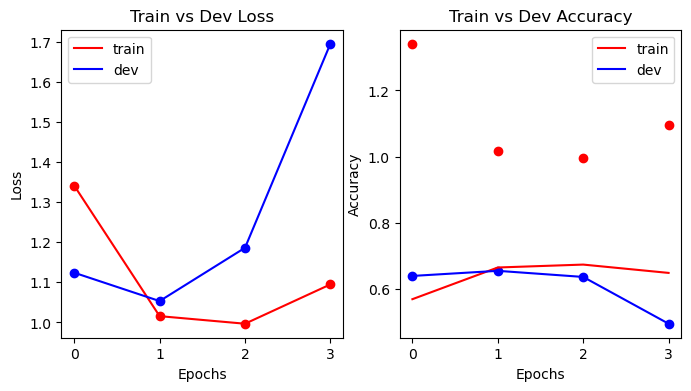

In [35]:
fig, (ax1, ax2) = plt.subplots(figsize = (8, 4), nrows = 1, ncols=2)

ax1.plot(range(epochs), train_loss, label='train', color='red')
ax1.scatter(range(epochs), train_loss, color='red')
ax1.plot(range(epochs), val_loss, label='dev', color='blue')
ax1.scatter(range(epochs), val_loss, color='blue')
ax1.set(xlabel = 'Epochs', ylabel = 'Loss')
ax1.set_title('Train vs Dev Loss')
ax1.legend()

ax2.plot(range(epochs), train_acc, label='train', color='red')
ax2.scatter(range(epochs), train_acc, color='red')
ax2.plot(range(epochs), val_acc, label='dev', color='blue')
ax2.scatter(range(epochs), val_acc, color='blue')
ax2.set(xlabel = 'Epochs', ylabel = 'Accuracy')
ax2.set_title('Train vs Dev Accuracy')
ax2.legend()

fig.savefig('train_vs_test_loss_and_accuracy.jpg')
fig.show()

## Test Data Inference and submission file preparation

### Load the label list

In [ ]:
print(ID_Label_Map)
labels_list = []
for i in range(len(ID_Label_Map)):
    label = ID_Label_Map[str(i)]
    labels_list.append(label)

print(labels_list)

### Read testset

In [ ]:
rr_test_data = {}
with open('../../data/model_data/SAMPLE_SUBMISSION_RR.json.json', 'r') as fp:
    rr_test_data = json.load(fp)
print("# Documents: ", len(rr_test_data))

### Get predictions

In [ ]:
final_results = rr_test_data.copy()
for doc_index, entry in tqdm(enumerate(rr_test_data)):
    results = rr_test_data[doc_index]['annotations'][0]['result']
    for sent_index, sent in enumerate(results):
        
        #### Extracting the text from the test data
        sentence = sent['value']['text']
        sentence = sentence.replace(r'\s+', ' ').strip()

        #### Getting the lda output for the given sentence
        tokenized_sent = model.tokenizer.tokenize(sentence)
        lda_output = encode_input_lda(tokenized_sent, len(ID_Label_Map))
        lda_output = torch.from_numpy(lda_output)

        #### Getting input ids and attention mask from the model for the given sentence
        input_ids, attention_mask = encode_input([sentence], model.tokenizer)
        output = model(lda_output.to(device), input_ids.to(device), attention_mask.to(device)).cpu().detach().numpy()
        
        label = None
        #### Predicting the label index from the model
        with th.no_grad():
            model.eval()
            model.to(device)
            y_pred = model(output.to(device), input_ids.to(device), attention_mask.to(device)).cpu()
            label = labels_list[np.argmax(y_pred)]
        
        if label is not None:
            final_results[doc_index]['annotations'][0]['result'][sent_index]['value']['labels'] = [label]
        else:
            print("Label is None for Doc-index: {} and Sent-index: {}".format(doc_index, sent_index))

print("# Documents: ", len(final_results))

In [ ]:
with open('../../output/RR_SUBMISSION.json', 'w') as fp:
    json.dump(final_results, fp, indent=4)